# Programming Exercise 2 - Logistic Regression

1. [Logistic Regression](#1.-Logistic-Regression)
    1. [Visualizing the data](#1.1-Visualizing-the-data)
    2. [Implementation](#1.2-Implementation)
        1. [Sigmoid function](#1.2.1-Sigmoid-function)
        2. [Cost function and gradient](#1.2.2-Cost-function-and-gradient)
        3. [Learning parameters using minimize functoin](#1.2.3-Learning-parameters-using-minimize-functoin)
        4. [Evaluating logistic regression](#1.2.4-Evaluating-logistic-regression)
2. [Regularized logistic regression](#2-Regularized-logistic-regression)
    1. [Visualizing the data](#2.1-Visualizing-the-data)
    2. [Feature mapping](#2.2-Feature-mapping)
    3. [Cost function and gradient](#2.3-Cost-function-and-gradient)
        1. [Learning parameters using minimize function](#2.3.1-Learning-parameters-using-minimize-function)
    4. [Plotting the decision boundary](#2.4-Plotting-the-decision-boundary)
    5. [Select regularization parameters](#2.5-Select-regularization-parameters)

In [1]:
import numpy as np
import pandas as pd
import sympy as sp
import mpmath as mp
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.preprocessing import PolynomialFeatures
from mpl_toolkits.mplot3d import Axes3D
from IPython.core.display import HTML, display
% matplotlib inline


In [2]:
def loadData(file):
    # load the dataset
    dataframe = pd.read_csv(file, sep=",", header=None, names=["exam 1", "exam 2", "admissions decision"])
    X, y = np.hsplit(dataframe.values, (-1,))
    # display data
    display(HTML(dataframe.head().to_html()))
    display(dataframe.describe())
    return X, y


In [3]:
def plotData(X, y, x_label=None, y_label=None, pos_label="positive", neg_label="negative", ax=None):
    # Find Indices of Positive and Negative Examples
    pos = np.where(y == 1)
    neg = np.where(y == 0)

    # If no specific axes object has been passed, get the current axes.
    if not ax:
        # get current axes
        ax = plt.gca()

    # Plot Examples
    ax.scatter(X[pos, 0], X[pos, 1], marker='+', c='black', label=pos_label)
    ax.scatter(X[neg, 0], X[neg, 1], marker='o', c='y', label=neg_label)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.legend(loc="upper right")


In [4]:
from math import factorial
from itertools import combinations_with_replacement as comb_w_r
from itertools import chain

# Note that this function inserts a column with 'ones' in the design matrix for the intercept
def featureMap(X, degree=2):
    n_samples, n_features = X.shape
    # generate combinations with repetitions
    combinations = chain.from_iterable(comb_w_r(range(n_features), i) for i in range(0, degree + 1))
    # calculate output shape
    n_output_features = sum([(factorial(n_features + i - 1) // (factorial(i) * factorial(n_features - 1))) for i in range(0, degree + 1)])
    # allocate output data
    XP = np.empty((n_samples, n_output_features), dtype=X.dtype)
    for i, c in enumerate(combinations):
        XP[:, i] = X[:, c].prod(1)
    return XP


In [5]:
# plot the decision boundary
def plotDecisionBoundary(axes, X, theta, degree=1):
    x1_min, x2_min = np.min(X, axis=0)
    x1_max, x2_max = np.max(X, axis=0)
    x1, x2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))
    h = hypot(theta, featureMap(np.column_stack((x1.flatten(), x2.flatten())), degree))
    h = h.reshape(x1.shape)
    # draw the Decision Boundary where the probability is 0.5
    axes.contour(x1, x2, h, levels=[0.5], linewidths=1, colors='b', label="Decision boundary")


## 1. Logistic Regression

In [6]:
X, y = loadData("machine-learning-ex2\ex2\ex2data1.txt")


,exam 1,exam 2,admissions decision
0,34.623660,78.024693,0
1,30.286711,43.894998,0
2,35.847409,72.902198,0
3,60.182599,86.308552,1
4,79.032736,75.344376,1


,exam 1,exam 2,admissions decision
count,100.000000,100.000000,100.000000
mean,65.644274,66.221998,0.600000
std,19.458222,18.582783,0.492366
min,30.058822,30.603263,0.000000
25%,50.919511,48.179205,0.000000
50%,67.032988,67.682381,1.000000
75%,80.212529,79.360605,1.000000
max,99.827858,98.869436,1.000000


### 1.1 Visualizing the data

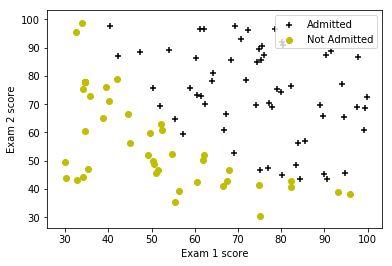

In [7]:
# Before starting to implement any learning algorithm,
# it is always good to visualize the data if possible.
plotData(X, y, x_label="Exam 1 score", y_label="Exam 2 score", pos_label="Admitted", neg_label="Not Admitted")


### 1.2 Implementation

#### 1.2.1 Sigmoid function

$$
\begin{align}
h_{\theta}(x) &= g(\theta^{\mathbf{T}}x)\\
g(z) &= \frac{1}{1+e^{-z}}\\
\end{align}
$$

In [8]:
x = sp.Symbol("x")
# sigmoid function
expr = 1 / (1 + mp.e ** -x)
# make it as functoin
sigmoid = sp.lambdify(x, expr)


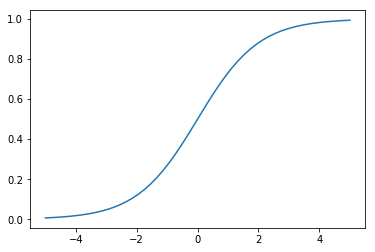

In [9]:
# plot sigmoid function
X_nums = np.linspace(-5, 5)
plt.plot(X_nums, sigmoid(X_nums))
plt.show()


#### 1.2.2 Cost function and gradient

$$
\begin{equation}
\begin{split}
J(\theta) & = \frac{1}{m}\sum_{i=1}^{m}\big[-y^{(i)}log(h_{\theta}(x^{(i)}))-(1-y^{(i)})log(1-h_{\theta}(x^{(i)}))\big]\\
& = -\frac{1}{m}\big((log(g(X\vec{\theta}))^{\mathbf{T}}\vec{y}+(log(1-g(X\vec{\theta}))^{\mathbf{T}}\vec{(1-y)}\big)\\
\end{split}
\end{equation}
$$

In [10]:
def hypot(theta, X):
    return sigmoid(X.dot(theta.reshape(-1, 1)))


In [11]:
def costFunction(theta, X, y):
    h = hypot(theta, X)
    return (-(np.log(h).T.dot(y) + np.log(1 - h).T.dot(1 - y)) / y.size).item()


$$
\begin{gather*}
\frac{\partial J(\theta)}{\partial\theta_{j}} = \frac{1}{m}\sum_{i=1}^{m}(h_{\theta}(x^{(i)})-y^{(i)})x_{j}^{(i)}\\
\frac{\partial J(\theta)}{\partial\theta} = \frac{1}{m}X^{\mathbf{T}}(g(X\vec{\theta})-\vec{y})\\
\end{gather*}
$$

In [12]:
def gradient(theta, X, y):
    h = hypot(theta, X)
    grad = X.T.dot(h - y) / y.size
    return grad.flatten()


In [13]:
X_with_ones = np.column_stack((np.ones(y.size), X))
initial_theta = np.zeros((X_with_ones.shape[1], 1))
cost = costFunction(initial_theta, X_with_ones, y)
grad = gradient(initial_theta, X_with_ones, y)
print('Cost: \n', cost)
print('Grad: \n', grad)


Cost: 
 0.6931471805599452
Grad: 
 [ -0.1        -12.00921659 -11.26284221]


#### 1.2.3 Learning parameters using minimize functoin

In [14]:
# Set options for minimize function
# Run minimize to obtain the optimal theta
# This function will return theta and the cost
res = minimize(costFunction, initial_theta, args=(X_with_ones, y), method="Newton-CG", jac=gradient, options={
    'maxiter': 400
})

# Onece it completes, you should see that the cost is about 0.203
res


     fun: 0.2034977176698254
     jac: array([  1.00352564e-05,   4.45730944e-04,   4.17245170e-04])
 message: 'Optimization terminated successfully.'
    nfev: 71
    nhev: 0
     nit: 28
    njev: 242
  status: 0
 success: True
       x: array([-25.15093692,   0.20614871,   0.20138731])

#### 1.2.4 Evaluating logistic regression

In [15]:
# The predict function will produce "1" or "0" 
# given a dataset and a learned parameter vector theta
def predict(theta, X, threshold=0.5):
    p = hypot(theta, X)
    return (p > threshold).astype("int")

def test_accuracy(theta, X, y):
    r = predict(theta.reshape(-1, 1), X)
    return np.where(r == y)[0].size / y.size


In [16]:
# predict for a student with an Exam 1 score of 45 and an Exam 2 score of 85
# you should expect to see an admission probability of 0.776
hypot(res.x, np.array([1, 45, 85]))


array([ 0.77620331])

In [17]:
print('Train accuracy {}%'.format(test_accuracy(res.x, X_with_ones, y)))


Train accuracy 0.89%


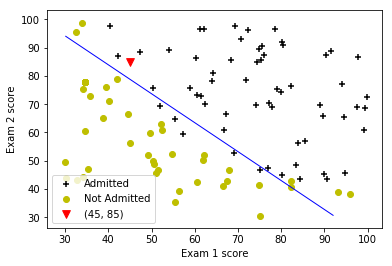

In [18]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plotData(X, y, x_label="Exam 1 score", y_label="Exam 2 score", pos_label="Admitted", neg_label="Not Admitted", ax=ax)
ax.scatter(45, 85, s=60, c='r', marker='v', label='(45, 85)')
plotDecisionBoundary(ax, X, res.x)
ax.legend()


## 2 Regularized logistic regression

In [19]:
X2, y2 = loadData('machine-learning-ex2\ex2\ex2data2.txt')


,exam 1,exam 2,admissions decision
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


,exam 1,exam 2,admissions decision
count,118.000000,118.000000,118.000000
mean,0.054779,0.183102,0.491525
std,0.496654,0.519743,0.502060
min,-0.830070,-0.769740,0.000000
25%,-0.372120,-0.254385,0.000000
50%,-0.006336,0.213455,0.000000
75%,0.478970,0.646562,1.000000
max,1.070900,1.108900,1.000000


### 2.1 Visualizing the data

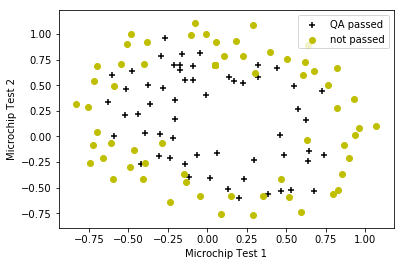

In [20]:
plotData(X2, y2, x_label="Microchip Test 1", y_label="Microchip Test 2", pos_label="QA passed", neg_label="not passed")


### 2.2 Feature mapping

In [21]:
# One way to fit the data better is to create more features from each data point.
mapFeatureX = featureMap(X2, 6)
# As a result of this mapping, our vector of two features
# has been transformed into a 28-dimensional vector.
mapFeatureX.shape
# While the feature mapping allows us to build a more expressive classifier,
# it also more susceptible to overfitting


(118, 28)

### 2.3 Cost function and gradient

$$
\begin{equation}
J_{reg}(\theta) = J(\theta) + \frac{\lambda}{2m}\sum_{j=1}^{n}\theta_{j}^{2}\\
\end{equation}
$$

In [22]:
def costFunctionReg(theta, X, y, _lambda=1):
    reg_term = _lambda * np.sum(np.square(theta.flatten()[1:])) / y.size / 2
    return costFunction(theta, X, y) + reg_term


$$
\begin{equation}
\begin{split}
\frac{\partial J_{reg}(\theta)}{\partial\theta_{j}} = \frac{\partial J(\theta)}{\partial\theta_{j}} + \frac{\lambda}{m}\theta_{j}& \text{ with }\ j\geq 1 \\
\end{split}
\end{equation}
$$

In [23]:
def gradientReg(theta, X, y, _lambda=1):
    grad = gradient(theta, X, y)
    reg_grad = (theta * _lambda / y.size).flatten()
    reg_grad[0] = 0
    return grad + reg_grad


In [24]:
initial_theta2 = np.zeros((mapFeatureX.shape[1], 1))
costFunctionReg(initial_theta2, mapFeatureX, y2, 1)


0.69314718055994529

#### 2.3.1 Learning parameters using minimize function

In [25]:
def min_logistic(theta, X, y, _lambda=1):
    return minimize(costFunctionReg, theta, args=(mapFeatureX, y2, _lambda), method=None, jac=gradientReg, options={
        'maxiter': 3000
    })
res2 = min_logistic(initial_theta2, mapFeatureX, y2)
if res2.success:
    print(f"final cost of theta {res2.x} is {res2.fun}")
res2.message


final cost of theta [ 1.27268739  0.62557016  1.1809665  -2.01919822 -0.91761468 -1.43194199
  0.12375921 -0.36513086 -0.35703388 -0.17485805 -1.45843772 -0.05129676
 -0.61603963 -0.2746414  -1.19282569 -0.24270336 -0.20570022 -0.04499768
 -0.27782709 -0.29525851 -0.45613294 -1.04377851  0.02762813 -0.29265642
  0.01543393 -0.32759318 -0.14389199 -0.92460119] is 0.5290027422869215


'Optimization terminated successfully.'

### 2.4 Plotting the decision boundary

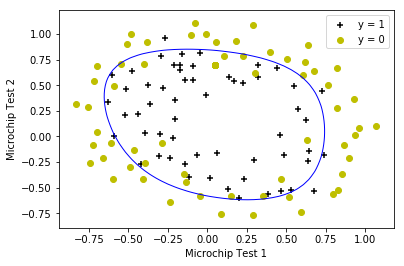

In [26]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plotData(X2, y2, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0', ax)
plotDecisionBoundary(ax, X2, res2.x, 6)


### 2.5 Select regularization parameters

C:\Users\vitam\Anaconda3\lib\site-packages\numpy\__init__.py:1: RuntimeWarning: overflow encountered in power
  """


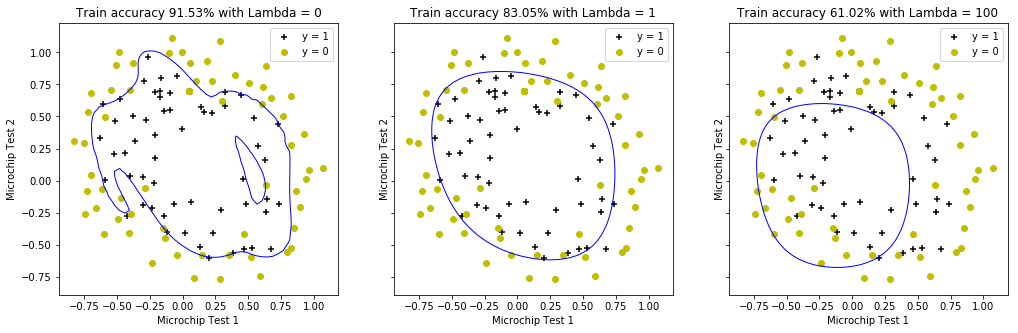

In [27]:
fig, axes = plt.subplots(1, 3, sharey=True, figsize=(17, 5))
# try out different regularization parameters

# Lambda = 0 : No regularization --> too flexible, overfitting the training data
# With a small lambda, the classifier gets almost every training example correct
# But draws a very complicated boundary, thus overfitting the data

# Lambda = 1 : Looks about right
# Lambda = 100 : Too much regularization --> high bias
# if lambda is set to too high, 
# you will not get a good fit
# thus underfitting the data

for i, _lambda in enumerate([0, 1, 100]):
    ax = axes.flatten()[i]
    # Optimize costFunctionReg
    res2 = min_logistic(initial_theta2, mapFeatureX, y2, _lambda)
    # Accuracy
    accuracy = 100 * test_accuracy(res2.x, mapFeatureX, y2)

    # Scatter plot of X,y
    plotData(X2, y2, 'Microchip Test 1', 'Microchip Test 2', 'y = 1', 'y = 0', ax)

    # Plot decisionboundary
    plotDecisionBoundary(ax, X2, res2.x, 6)
    ax.set_title(f"Train accuracy {np.round(accuracy, decimals=2)}% with Lambda = {_lambda}")
